In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 

In [12]:
seedPoints = []

##### User Input

Asks the user for input to get the seeds.

The user must click on the objects it wants the algorithm to detect (can be more than one)

In [13]:
IMG = cv2.imread("testImg1.jpg")

In [14]:
# Mouse callback functionw
def getCoords(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        seedPoints.append((x, y))
        print(f"Seed set at: ({x}, {y})")

        cv2.circle(seededImage, (x, y), 5, (0,0,255), -1)
        cv2.imshow("InputImage", seededImage)

# Load and display the image
seededImage = IMG.copy()
cv2.imshow("InputImage", seededImage)
cv2.setMouseCallback("InputImage", getCoords)

# Wait until any key is pressed to close the window
cv2.waitKey(0)
cv2.destroyAllWindows()

Seed set at: (679, 367)


Get the RGB versions of both seeded and unseeded images

In [15]:
image = cv2.cvtColor(IMG, cv2.COLOR_BGR2RGB)
seededImage = cv2.cvtColor(seededImage, cv2.COLOR_BGR2RGB)

##### Region Growing Algorithm

In [18]:
objectImage = np.zeros_like(image)

In [17]:
for seed in seedPoints:
    # Get the neighbors of the current point 
    # NOTE TO SELF. Numpy keeps the image's shape inverted (width, length, RGB) is instead (length, width, RGB)
    neighbors = [
        image[seed[1]-1, seed[0]],
        image[seed[1]+1, seed[0]],
        image[seed[1], seed[0]-1],
        image[seed[1], seed[0]+1]
    ]
    
    # Add them to a queue
    toExploreQueue = list(neighbors)
    
    # While the queue has elements to explore, keep iterating
    while len(toExploreQueue) > 0:

        visit = toExploreQueue.pop()

        # Determine if the explored pixel is similar enough based on _
        if (seed == visit):
            pass

KeyboardInterrupt: 

##### Results

Display the original and resulting images

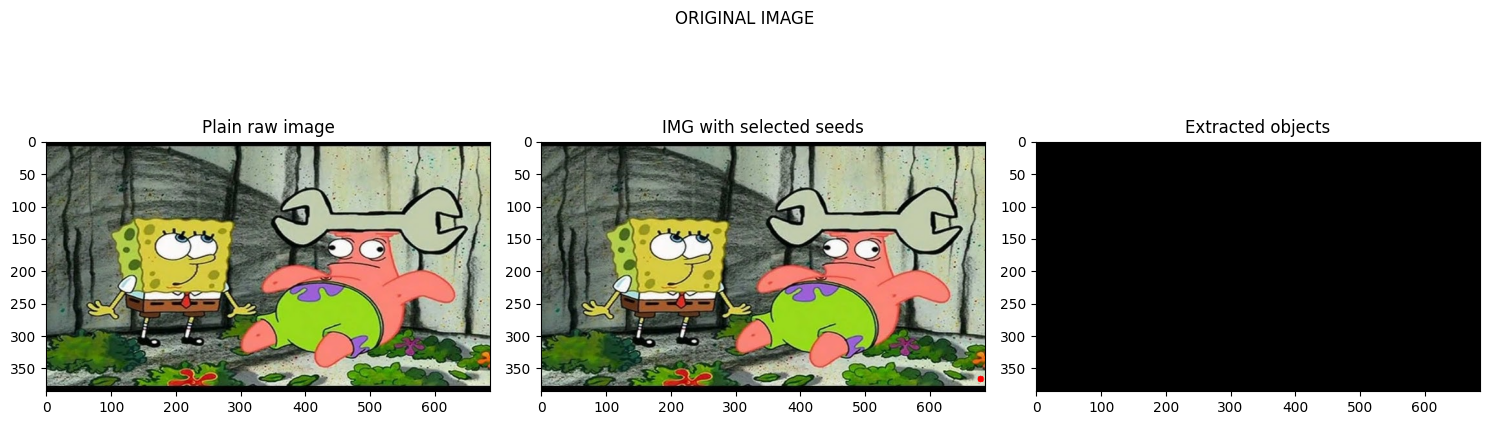

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("ORIGINAL IMAGE")

ax[0].imshow(image)
ax[0].set_title("Plain raw image")

ax[1].imshow(seededImage)
ax[1].set_title("IMG with selected seeds")

ax[2].imshow(objectImage)
ax[2].set_title("Extracted objects")

plt.tight_layout()
plt.show()